# Home Depot Product Search Relevance 

# 1. Background

In this project, we are given a dataset that contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters. The relevance is a number between 1 (not relevant) to 3 (highly relevant).

We are provided with the following information:

    id - a unique Id field which represents a (search_term, product_uid) pair
    product_uid - an id for the products
    product_title - the product title
    product_description - the text description of the product (may contain HTML content)
    search_term - the search query
    name - an attribute name
    value - the attribute's value
    relevance - the average of the relevance ratings for a given id

Our task is to build up a regression model, and for each id in the test set, it should predict a relevance, which is a real number in [1,3].

# 2. Data Explore

First of all, we want to read data to dataframes.

In [1]:
#To succesfully run this script, you need to install nltk package.
import numpy as np
import pandas as pd
#import pysaprk
from pyspark import SparkContext
from pyspark import SQLContext

In [2]:
#read data
df_train = pd.read_csv('./train.csv',encoding="ISO-8859-1")
df_test = pd.read_csv('./test.csv',encoding="ISO-8859-1")
attr = pd.read_csv("./attributes.csv")
desc = pd.read_csv('./product_descriptions.csv', encoding="ISO-8859-1")

We first can explore some basic information in train and test set.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


In [4]:
len(df_train['product_uid'].unique())

54667

In [5]:
len(df_test['product_uid'].unique())

97460

Based on number of products in training set and test set, there are around twice more numbers of products in test set than training set, which means the features(word) of half instances in test set might have never showed up in training set. This could be a big challenge for prediction on test set, as there could be many new features if word2vec or one-hot features were used. 


I also explored the distribution of relevance in training set.

In [6]:
df_train["relevance"].describe()

count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

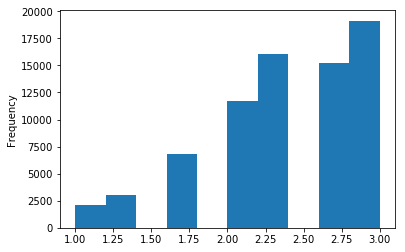

In [8]:
df_train["relevance"].plot.hist()

The relevance is skewed in training data, while as the frequency is high enough for regression, this is not a big problem.

Then training set and test set were combined together.

In [9]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

As different product has different numbers of attributes in attribute file, I want to combine them together, so it can be treated as anouther description feature.

In [10]:
#join values of all names of one product
def join_values(attribute):
    #name = attribute["name"]
    values = attribute["value"]
    values_str= [str(i) for i in values.tolist()]
    result= " ".join(values_str)
    return result
    
newAttr= attr.groupby(["product_uid"]).apply(join_values)

In [11]:
attr = newAttr.reset_index(name="product_attributes")

In [12]:
attr

,product_uid,product_attributes
0,100001.0,Versatile connector for various 90° connection...
1,100002.0,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
2,100003.0,Yes Slightly narrower for tighter spaces Desig...
3,100004.0,8.56 Positive power tolerance (0 to +5-Watt) A...
4,100005.0,Combo Tub and Shower No Includes the trim kit ...
5,100006.0,Over the Range Microwave 18.5 in 17.13 in 29.9...
6,100007.0,Ni-Cad .Built-In LED Advanced LED technology i...
7,100008.0,.375 in 1.5 in .375 in For metal to metal fast...
8,100009.0,Door & Window Made of primed MDF Can be painte...
9,100010.0,No Can be used with all valley View lawn edgin...


In [13]:
#two new features, product description and attributes, are merged to dataframe
df_all = pd.merge(df_all, desc, how='left', on='product_uid')
df_all = pd.merge(df_all, attr, how="left", on="product_uid")


In [14]:
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
product_attributes     194935 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB


In [15]:
#fill in the missing values in product_attributes
df_all["product_attributes"] = df_all["product_attributes"].fillna("")

In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
product_attributes     240760 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB


In [17]:
#####
#sc = SparkContext()
#sqlContext = SQLContext(sc)

In [18]:
#df_spark = sqlContext.createDataFrame(df_all)
#df_spark.printSchema()

# 3. text pre-processing

Text pre-processing was splited to two phases: First, substitution was performed to clean the meaningless symbols and synonyms. Then Stemmers remove morphological affixes from words, leaving only the word stem. 

In [19]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [20]:
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#stemmer

In [38]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()


In [22]:
#text cleaning for "product_title", "product_description", and "search_term"
def pre_word(line):
    line = line.lower()
    line = line.replace("  "," ")
    line = line.replace(",","") #transfer format like 10,000 to 10000
    line = line.replace("one","1")
    line = line.replace("two","2")
    line = line.replace("three","3")
    line = line.replace("four","4")
    line = line.replace("five","5")
    line = line.replace("six","6")
    line = line.replace("seven","7")
    line = line.replace("eight","8")
    line = line.replace("nine","9")
    line = line.replace("zero","0")
    line = line.replace("(","")
    line = line.replace(")","")
    
    words = line.split(" ")
    newWords=[]
    for word in words:
        word2 = lmtzr.lemmatize(word)
        if word2 not in stop:
            newWords.append(word2)
        #newWords.append(stemmer.stem(word))
    return " ".join(newWords)

In [39]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/jingzhip/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [23]:
###from pyspark.sql.functions import udf
###from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [24]:
###udf_pre=udf(pre_word, StringType())

In [25]:
###df_spark = df_spark.withColumn("product_title_stem", udf_pre("product_title"))

In [26]:
###df_spark.printSchema()

In [27]:
###df_spark.drop(df_spark.product_title).collect()

In [28]:
###df_spark.printSchema()

In [29]:
###df_spark = df_spark.withColumn("product_description_stem", udf_pre("product_description"))

In [30]:
###df_spark = df_spark.withColumn("search_term_stem", udf_pre("search_term"))

In [70]:
#"product_attributes" need to be decoded with utf-8, so a new stem_word function was used
def pre_word2(line):
    line = line.lower()
    line = line.replace("  "," ")
    line = line.replace(",","") #transfer format like 10,000 to 10000
    line = line.replace("one","1")
    line = line.replace("two","2")
    line = line.replace("three","3")
    line = line.replace("four","4")
    line = line.replace("five","5")
    line = line.replace("six","6")
    line = line.replace("seven","7")
    line = line.replace("eight","8")
    line = line.replace("nine","9")
    line = line.replace("zero","0")
    line = line.replace("(","")
    line = line.replace(")","")


    words = line.split(" ")
    newWords=[]
    for word in words:
        word2 = lmtzr.lemmatize(word.decode('utf-8','ignore'))
        if word2 not in stop:
            newWords.append(word2)
    return " ".join(newWords)

In [32]:
###df_spark = df_spark.withColumn("product_attributes_stem", udf_pre("product_attributes"))

In [33]:
#write all text features to file
#df_all.to_csv('df_word.csv', encoding="utf-8")

In [34]:
#df_all

In [35]:
#save a copy
#df_copy = df_all.copy()

In [36]:
###df_spark.printSchema()

In [40]:
df_all["product_title"] = df_all["product_title"].apply(pre_word)

In [41]:
df_all["product_description"] = df_all["product_description"].apply(pre_word)

In [42]:
df_all["search_term"] = df_all["search_term"].apply(pre_word)

In [74]:
df_all["product_attributes"] = df_all["product_attributes"].apply(pre_word2)

# 4. Feature Engineering

Based on the product exploration of training and test set, I don't think word2vec or one-hot vector is a good choice for this dataset. One reason is that there are many new features haven't showed up in training set, so the feature space is incomplete, which brings unaviodable error, the other reason is, as the dataset is large, there could be a huge number of features if we use word2vec. 

Basicly, the relevance is most related to the similarity between search term and product itself. So creating features that describe the similarity between search term and the product should be meaningful. Two different ways could be used to describe the similarity between search term and profuct information, the first one is, creating number of common words as features, which is the number of the same word that showed up in both search term and product descriptions.

In [44]:
#return number of common words in c1 and c2
def common_words(c1, c2):
    result=[]
    for term, title in zip(c1, c2):
        term_list = term.split(" ")
        title_list = title.split(" ")
        result.append(sum(int(i in title_list) for i in term_list))
    return result

In [45]:
#calculate number of common words between search term and title, description, attributes 
search_term = df_all["search_term"]
product_title = df_all["product_title"]
product_description = df_all["product_description"]
product_attributes = df_all["product_attributes"]

In [46]:
#search_term = df_spark.select("search_term").rdd.flatMap(lambda x: x).collect()
#product_title = df_spark.select("product_title").rdd.flatMap(lambda x: x).collect()
#product_description = df_spark.select("product_description").rdd.flatMap(lambda x: x).collect()
#product_attributes = df_spark.select("product_attributes").rdd.flatMap(lambda x: x).collect()

In [47]:
common_search_title = common_words(search_term, product_title)
common_search_description = common_words(search_term, product_description)
common_search_attributes = common_words(search_term, product_attributes)

/home/jingzhip/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [48]:
df_all["common_search_title"] = common_search_title
df_all["common_search_description"] = common_search_description
df_all["common_search_attributes"] = common_search_attributes

I also created features showing the number of words in search term feature. A meaningful feature would be the ratio of words that perfectly mathed between search query and other text attributes.

In [50]:
#length of search term
df_all["len_search_term"] = [ len(term.split(" ")) for term in search_term]

In [ ]:
#df_all["len_product_title"] = [ len(title.split(" ")) for title in product_title]
#df_all["len_product_description"] = [ len(desc.split(" ")) for desc in product_description]
#df_all["len_product_attributes"] = [ len(attribute.split(" ")) for attribute in product_attributes]

In [52]:
#the ratio of words in search term that hit product title
df_all['ratio_search_title'] = df_all["common_search_title"] / df_all["len_search_term"]

In [54]:
#the ratio of words in search term that hit product discription
df_all['ratio_search_description'] = df_all["common_search_description"] / df_all["len_search_term"]

In [77]:
#the ratio of words in search term that hit product attributes
df_all['ratio_search_attri'] = df_all["common_search_attributes"] / df_all["len_search_term"]

Another way to show the similarity between search term and product information is the cosine similarity. We need to first transform the text to tfidf vectors and then calculate cosine similarity between the search term and each product information. 

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

In [78]:
#return cosine similarity between search_term(c1) and title(c2)
def cal_cosine(c1, c2):
    result=[]
    for term, title in zip(c1, c2):
        corpus = [term, title]
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
        cosine = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[0])
        result.append(cosine[0][0])
    return result

In [79]:
#calculate the cosine similarity between search term and product title 
df_all['cos_search_title'] = cal_cosine(df_all["search_term"], df_all["product_title"])
#calculate the cosine similarity between search term and product description
df_all['cos_search_description'] = cal_cosine(df_all["search_term"], df_all["product_description"])

In [88]:
df_all

,id,product_title,product_uid,relevance,search_term,product_description,product_attributes,common_search_title,common_search_description,common_search_attributes,len_search_term,ratio_search_title,ratio_search_description,ratio_search_attri,cos_search_title,cos_search_description
0,2,simpson strong-tie 12-gauge angle,100001,3.00,angle bracket,angle make joint stronger also provide consist...,versatile connector various 90° connection hom...,1,1,0,2,0.500000,0.500000,0.000000,0.175786,0.074682
1,3,simpson strong-tie 12-gauge angle,100001,2.50,l bracket,angle make joint stronger also provide consist...,versatile connector various 90° connection hom...,0,0,0,2,0.000000,0.000000,0.000000,0.000000,0.000000
2,9,behr premium textured deckover 1-gal. #sc-141 ...,100002,3.00,deck,behr premium textured deckover innovative soli...,brushrollerspray 6.63 7.76 6.63 revives wood c...,0,1,1,1,0.000000,1.000000,1.000000,0.000000,0.164410
3,16,delta vero 1-handle shower faucet trim kit chr...,100005,2.33,rain shower head,update bathroom delta vero single-handle showe...,combo tub shower includes trim kit rough-in ki...,1,1,2,3,0.333333,0.333333,0.666667,0.103716,0.034786
4,17,delta vero 1-handle shower faucet trim kit chr...,100005,2.67,shower faucet,update bathroom delta vero single-handle showe...,combo tub shower includes trim kit rough-in ki...,2,2,2,2,1.000000,1.000000,1.000000,0.335176,0.109780
5,18,whirlpool 1.9 cu. ft. range convection microwa...,100006,3.00,convection otr,achieving delicious result almost effortless w...,range microwave 18.5 17.13 29.94 spacious 1.9 ...,1,1,1,2,0.500000,0.500000,0.500000,0.133785,0.056757
6,20,whirlpool 1.9 cu. ft. range convection microwa...,100006,2.67,microwave stove,achieving delicious result almost effortless w...,range microwave 18.5 17.13 29.94 spacious 1.9 ...,1,1,1,2,0.500000,0.500000,0.500000,0.133785,0.056757
7,21,whirlpool 1.9 cu. ft. range convection microwa...,100006,3.00,microwave,achieving delicious result almost effortless w...,range microwave 18.5 17.13 29.94 spacious 1.9 ...,1,1,1,1,1.000000,1.000000,1.000000,0.230768,0.097901
8,23,lithonia lighting quantum 2-light black led em...,100007,2.67,emergency light,quantum adjustable 2-light led black emergency...,ni-cad .built-in led advanced led technology d...,1,2,2,2,0.500000,1.000000,1.000000,0.355477,0.178532
9,27,house fara 3/4 in. x 3 in. x 8 ft. mdf fluted ...,100009,3.00,mdf 3/4,get house fara 3/4 in. x 3 in. x 8 ft. mdf flu...,door & window made primed mdf painted match de...,2,2,1,2,1.000000,1.000000,0.500000,0.230768,0.085343


Now all the text features are transfromed to numerical fetaures, and text features could be dropped.

In [112]:
#drop text features
df = df_all.drop([ "product_title", "search_term", "product_description", "product_attributes"], axis=1)

In [113]:
df = df.drop(["common_search_title", "common_search_description","common_search_attributes"], axis=1)

# 5. Model Building

In this part, different regression models were built up to fit the dataset. 

#1. data preparation <br>
First, the dataset should be transfered to spark platform and new dataframes should be created.

In [153]:
#split train and test set
train = df[:len(df_train)]
#train

In [115]:
test = df[len(df_train):]
test = test.drop(["relevance"], axis=1)

In [95]:
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [97]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [116]:
df_train_spark = sqlContext.createDataFrame(train)
df_train_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- relevance: double (nullable = true)
 |-- len_search_term: long (nullable = true)
 |-- ratio_search_title: double (nullable = true)
 |-- ratio_search_description: double (nullable = true)
 |-- ratio_search_attri: double (nullable = true)
 |-- cos_search_title: double (nullable = true)
 |-- cos_search_description: double (nullable = true)



In [117]:
df_test_spark = sqlContext.createDataFrame(test) 
df_test_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- len_search_term: long (nullable = true)
 |-- ratio_search_title: double (nullable = true)
 |-- ratio_search_description: double (nullable = true)
 |-- ratio_search_attri: double (nullable = true)
 |-- cos_search_title: double (nullable = true)
 |-- cos_search_description: double (nullable = true)



#2. Model Building <br>
Random forest regression is a good choice, as it is an ensemble method, in which the final prediction is based on the mean prediction of each tree. Overfitting could be avoided in this way. I started with random forest regression model.

We start with a baseline model. In order to evaluate the model performance during the training process, a part of data were randomly extracted from training set and performed as validation set, which performed as test data during training process. Defaulte paramteres were used for baseline builder.

In [104]:
from pyspark.ml.feature import VectorAssembler

In [135]:
# Split the data into training and test sets (20% held out for testing)
(train, validation) = df_train_spark.randomSplit([0.8, 0.2])

In [136]:
#construct a feature vector as assembler
assembler = VectorAssembler(
    inputCols=[x for x in train.columns if x not in ['id', 'relevance']],
    outputCol='features')
#assembler.transform(df_train_spark)
assembler.transform(train)
assembler.transform(validation)
assembler.transform(df_test_spark)

DataFrame[id: bigint, product_uid: bigint, len_search_term: bigint, ratio_search_title: double, ratio_search_description: double, ratio_search_attri: double, cos_search_title: double, cos_search_description: double, features: vector]

In [141]:
# Train a RandomForest model.
rf_reg = RandomForestRegressor(featuresCol="features", labelCol="relevance", numTrees=500)

In [142]:
# Chain indexer and forest in a Pipeline
pipeline1 = Pipeline(stages=[assembler, rf_reg])

In [143]:
# Train model.  This also runs the indexer.
model1 = pipeline1.fit(train)

In [138]:
# Make predictions.
predictions1 = model1.transform(validation)

Now we want to evaluate the performance of baseline model. I choose Root Mean Squared Error(RMSE), which was used in Kaggle for performance test. 

In [139]:
# Select (prediction, true relevance) and compute test error
evaluator1 = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")
rmse = evaluator1.evaluate(predictions1)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.485198


The baseline has 0.485 RMSE on validation set. Then prediction on test dataset was performed and the relevance score were output to a csv file for Kaggle test.

In [ ]:
#predictionon test set
predictions1 = model1.transform(df_test_spark)

In [ ]:
#write to csv
test_mat= prediction1.toPandas()
test_mat.to_csv('pred.csv', columns = ["id", "relevance"], index = False)

The model with default parameters of random forest regressor gave private score of 0.48796 on Kaggle. It is not a very good score on leaderborad, one of the reasons could be that there is no parameter optimization on regression model.

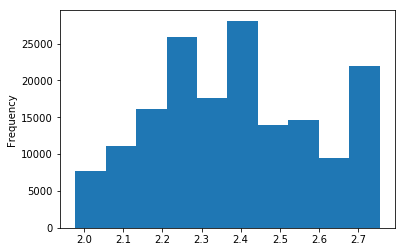

In [152]:
test_mat["relevance"].plot.hist()

Obviously, the distribution of predictions on test set is highly skewed, as all of the predictions are no smaller than 2.0. Suppose the training set and test set have the same distribution, then all the instances that have low relevance score will make strong contributions to RMSE. It also suggested that more optimization should be performed on current model.

# Next Stage
In the next stage, I will do more optimization on current model, including parameter grid search and cross validation. Feature importance will be analyzed. Besides, the dataset will be transfered to MongoDB so new modual about data import will be implemented. 

In [145]:
rf = RandomForestRegressor(featuresCol="features", labelCol="relevance")

In [147]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [148]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20,50,100,200,500])\
    .addGrid(rf.maxDepth, [1,2,3,5,10])\
    .build()

In [149]:
evaluator1 = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")

In [150]:
crossval = CrossValidator(estimator=pipeline1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator1,
                          numFolds=5)

In [151]:
CV_model = crossval.fit(df_train_spark)

KeyboardInterrupt: 

In [ ]:
tree_model = CV_model.bestModel.stages[2]
print tree_model

In [ ]:
'''
steps:
1. data cleaning:
    replace "," to " "
    replace "." to " "
    ...
    Synonyms substitution

2. feature engineering
    length of query
    length of description
    TFIDF

3. model building
    RF, GBM
4. model optimization
    paramgridbuilder()


'''